# 贪婪算法的不同和优化

## 现在将创建不同的 Agent 并统计平均值，后悔值，命中率

In [1]:
from typing import Callable, List, Tuple
import gc

from core import EpsilonDecreasingConfig, GreedyAgent, Rewards, RLEnv
from train import train, AverageMetrics
from algorithms import greedy_average, epsilon_average, epsilon_decreasing_average

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

from pathlib import Path

import json

In [2]:
SEED = 42
env = RLEnv(machine_count=100, seed=SEED)
COUNT = 50
STEPS = 10_000
CONVERGENCE_THRESHOLD = 0.9
CONVERGENCE_MIN_STEPS = 1000
EXPERMENT_DATA_FOLDER = Path.cwd() / "experiment_data"
OPTIMISTIC_TIMES = 100

In [3]:
def batch_train(
    count: int,
    greedy_algorithm: Callable[..., int],
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    steps: int,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> Tuple[List[GreedyAgent], Rewards, AverageMetrics]:
    """批训练 Agent，传入数量，不同的算法，环境，步数和初始种子即可训练

    Args:
        count (int): 训练数量
        agent (GreedyAgent): 算法 类型
        env (RLEnv): 环境
        steps (int): 步数
        seed (int): 初始种子

    Returns:
        Tuple[List[GreedyAgent], Rewards]: 返回训练后的 agents 和平均后的奖励
    """
    _agents: List[GreedyAgent] = []

    if not callable(greedy_algorithm):
        raise ValueError("算法必须传入一个函数")

    for i in range(count):
        _agents.append(
            GreedyAgent(
                name=greedy_algorithm.__name__,  # type: ignore # 在 callable 这里就已经验证了是一个函数，这里是为了避免 ty 工具误报
                env=env,
                greedy_algorithm=greedy_algorithm,
                epsilon_config=epsilon_config,
                optimistic_init=optimistic_init,
                optimistic_times=optimistic_times,
                convergence_threshold=convergence_threshold,
                convergence_min_steps=convergence_min_steps,
                seed=seed + i,
            )
        )

    agents, reward, metrics = train(_agents, steps)

    return agents, reward, metrics


def plot_metrics_history(agents: List[GreedyAgent], agent_name: str, file_name: str):
    """
    根据训练后的一组 agent 的 metrics_history 绘制指标变化图。

    Args:
        agents (List[GreedyAgent]): 经过训练的 agent 列表。
        agent_name (str): 这组 agent 的名称，用于图表标题。
        file_name (str): 保存的文件名（例如："experiment_result.png"）
    """

    if not agents:
        raise ValueError("Agents 列表为空，无法绘图")

    # 1. 设置字体
    font_path = Path.cwd() / "assets" / "微软雅黑.ttf"
    if font_path.exists():
        font_prop = FontProperties(fname=font_path, size=12)
        title_font_prop = FontProperties(fname=font_path, size=16)
        print("成功加载字体：", font_path)

    else:
        print(f"警告：找不到字体文件 {font_path}，将使用默认字体，中文可能显示为方框。")
        font_prop = FontProperties(size=12)
        title_font_prop = FontProperties(size=16)

    # 2. 准备数据
    num_steps: int = agents[0].steps

    avg_history = {
        "regret": np.zeros(num_steps),
        "regret_rate": np.zeros(num_steps),
        "total_reward": np.zeros(num_steps),
        "optimal_rate": np.zeros(num_steps),
        "convergence_steps": np.zeros(num_steps),
        "convergence_rate": np.zeros(num_steps),
    }

    # 遍历每个时间步
    for step_idx in range(num_steps):
        # 临时存储当前时间步所有 agent 的指标
        step_metrics = {
            "regret": [],
            "regret_rate": [],
            "total_reward": [],
            "optimal_rate": [],
            "convergence_steps": [],
            "convergence_rate": [],
        }
        # 遍历每个 agent
        for agent in agents:
            # agent.metrics_history 的索引与 step_idx 一致
            if step_idx < len(agent.metrics_history):
                metrics_at_step = agent.metrics_history[step_idx][
                    1
                ]  # (Rewards, Metrics, int) -> Metrics
                step_metrics["regret"].append(metrics_at_step.regret)
                step_metrics["regret_rate"].append(metrics_at_step.regret_rate)
                step_metrics["total_reward"].append(sum(metrics_at_step.rewards.values))
                step_metrics["optimal_rate"].append(metrics_at_step.optimal_rate)
                step_metrics["convergence_steps"].append(agent.convergence_steps)
                step_metrics["convergence_rate"].append(1 if agent.convergence_steps > 0 else 0)

        # 计算当前时间步的平均值并存入 avg_history
        for key in avg_history:
            if step_metrics[key]:  # 确保列表不为空
                avg_history[key][step_idx] = np.mean(step_metrics[key])

    steps_axis = np.arange(1, num_steps + 1)

    # 3. 开始绘图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
    fig.suptitle(f'"{agent_name}" 算法平均指标变化情况', fontproperties=title_font_prop)

    assert isinstance(axes, np.ndarray)
    axes = axes.flatten()

    plot_config = {
        "regret": "后悔值 (Regret)",
        "regret_rate": "后悔率 (Regret Rate)",
        "total_reward": "累积总奖励 (Total Reward)",
        "optimal_rate": "最优臂选择率 (Optimal Rate)",
        "convergence_steps": "达到收敛时的步数 (Convergence Steps)",
        "convergence_rate": "达到收敛率 (Convergence Rate)",
    }

    for i, (metric_key, title) in enumerate(plot_config.items()):
        ax = axes[i]
        ax.plot(steps_axis, avg_history[metric_key], label=title)
        ax.set_title(title, fontproperties=font_prop)
        ax.set_xlabel("时间步 (Steps)", fontproperties=font_prop)
        ax.set_ylabel("平均值", fontproperties=font_prop)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(prop=font_prop)

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()
    
    if not file_name.endswith(".png"):
        file_name += ".png"
    fig.savefig(EXPERMENT_DATA_FOLDER / file_name)
    print(f"✅ 实验数据已保存至 {file_name}")

def save_experiment_data(
    agents: List[GreedyAgent],
    reward: Rewards,
    metrics: AverageMetrics,
    file_name: str
):
    """
    将实验结果保存为 JSON 文件。
    
    Args:
        agents: 训练后的所有 agent 实例列表
        reward: 平均奖励信息
        metrics: 平均评估指标
        file_name: 保存的文件名（例如："experiment_result.json"）
    """
    
    # 转换 Agents 数据为可序列化的字典
    agents_data = []
    for agent in agents:
        agent_history = [
            {
                "step": step,
                "rewards": {
                    "values": list(rewards.values),
                    "counts": list(rewards.counts),
                    "q_values": list(rewards.q_values),
                },
                "metrics": {
                    "regret": m.regret,
                    "regret_rate": m.regret_rate,
                    "optimal_rate": m.optimal_rate,
                }
            }
            for rewards, m, step in agent.metrics_history
        ]
        
        agents_data.append({
            "name": agent.name,
            "seed": agent.seed,
            "steps": agent.steps,
            "convergence_steps": agent.convergence_steps,
            "history": agent_history,
            "final_rewards": {
                "values": list(agent.rewards.values),
                "counts": list(agent.rewards.counts),
                "q_values": list(agent.rewards.q_values),
            },
            "final_metrics": agent.metric().model_dump() if hasattr(agent.metric(), 'model_dump') else vars(agent.metric()),
        })

    # 构造最终输出的 JSON 数据
    experiment_data = {
        "average_reward": {
            "values": list(reward.values),
            "counts": list(reward.counts),
        },
        "average_metrics": {
            "avg_regret": metrics.avg_regret,
            "avg_regret_rate": metrics.avg_regret_rate,
            "avg_total_reward": metrics.avg_total_reward,
            "avg_optimal_rate": metrics.avg_optimal_rate,
            "avg_convergence_steps": metrics.avg_convergence_steps,
            "avg_convergence_rate": metrics.avg_convergence_rate,
        },
        "agents": agents_data,
    }

    # 写入文件
    if not EXPERMENT_DATA_FOLDER.exists():
        EXPERMENT_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
    with open(EXPERMENT_DATA_FOLDER / file_name, "w", encoding="utf-8") as f:
        json.dump(experiment_data, f, ensure_ascii=False, indent=4)

    print(f"✅ 实验数据已保存至 {file_name}")


## 平均奖励

### 普通贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


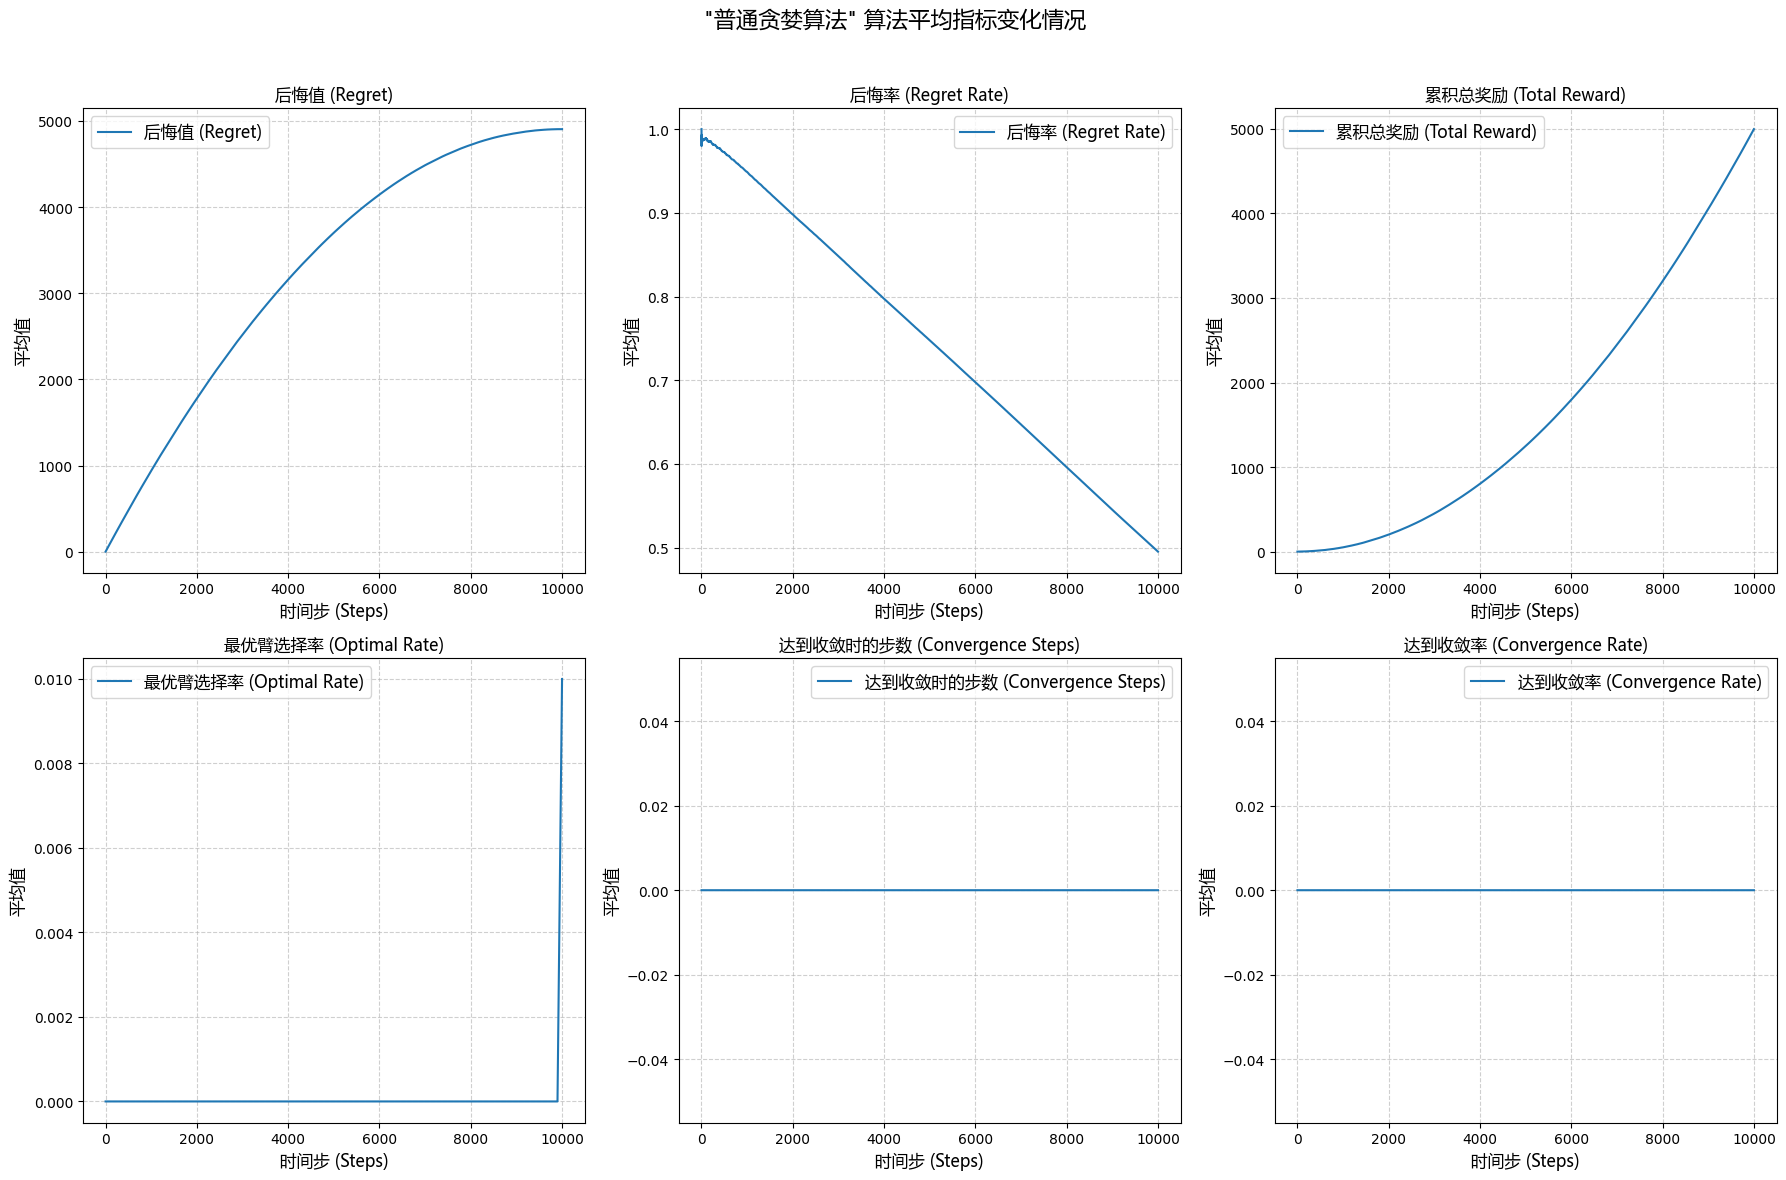

✅ 实验数据已保存至 greedy_average_Q_0=100.png
anget 名称: greedy_average
平均奖励：values=[1.1, 1.76, 2.74, 3.48, 4.5, 5.38, 6.44, 7.42, 8.32, 9.44, 10.64, 11.64, 12.44, 13.7, 14.56, 15.7, 16.68, 17.66, 18.68, 19.38, 20.58, 21.26, 22.32, 23.3, 24.18, 25.3, 26.34, 27.64, 28.48, 29.48, 30.74, 31.92, 32.92, 33.8, 34.72, 35.6, 36.46, 37.48, 38.7, 39.5, 40.36, 41.36, 42.44, 43.14, 44.0, 45.2, 46.2, 46.88, 47.82, 48.96, 50.12, 51.06, 52.06, 53.0, 54.24, 55.44, 56.44, 57.38, 58.32, 59.28, 60.12, 61.2, 62.22, 63.28, 64.36, 65.34, 66.66, 67.6, 68.7, 69.6, 70.88, 71.9, 72.88, 73.94, 74.88, 75.74, 76.64, 77.82, 78.8, 79.78, 80.62, 81.76, 82.72, 83.8, 84.82, 85.92, 86.98, 88.12, 88.96, 89.68, 90.4, 91.26, 92.18, 92.98, 93.98, 95.02, 95.72, 96.94, 97.84, 98.84] counts=[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100

21670

In [4]:
# 普通贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=greedy_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="普通贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


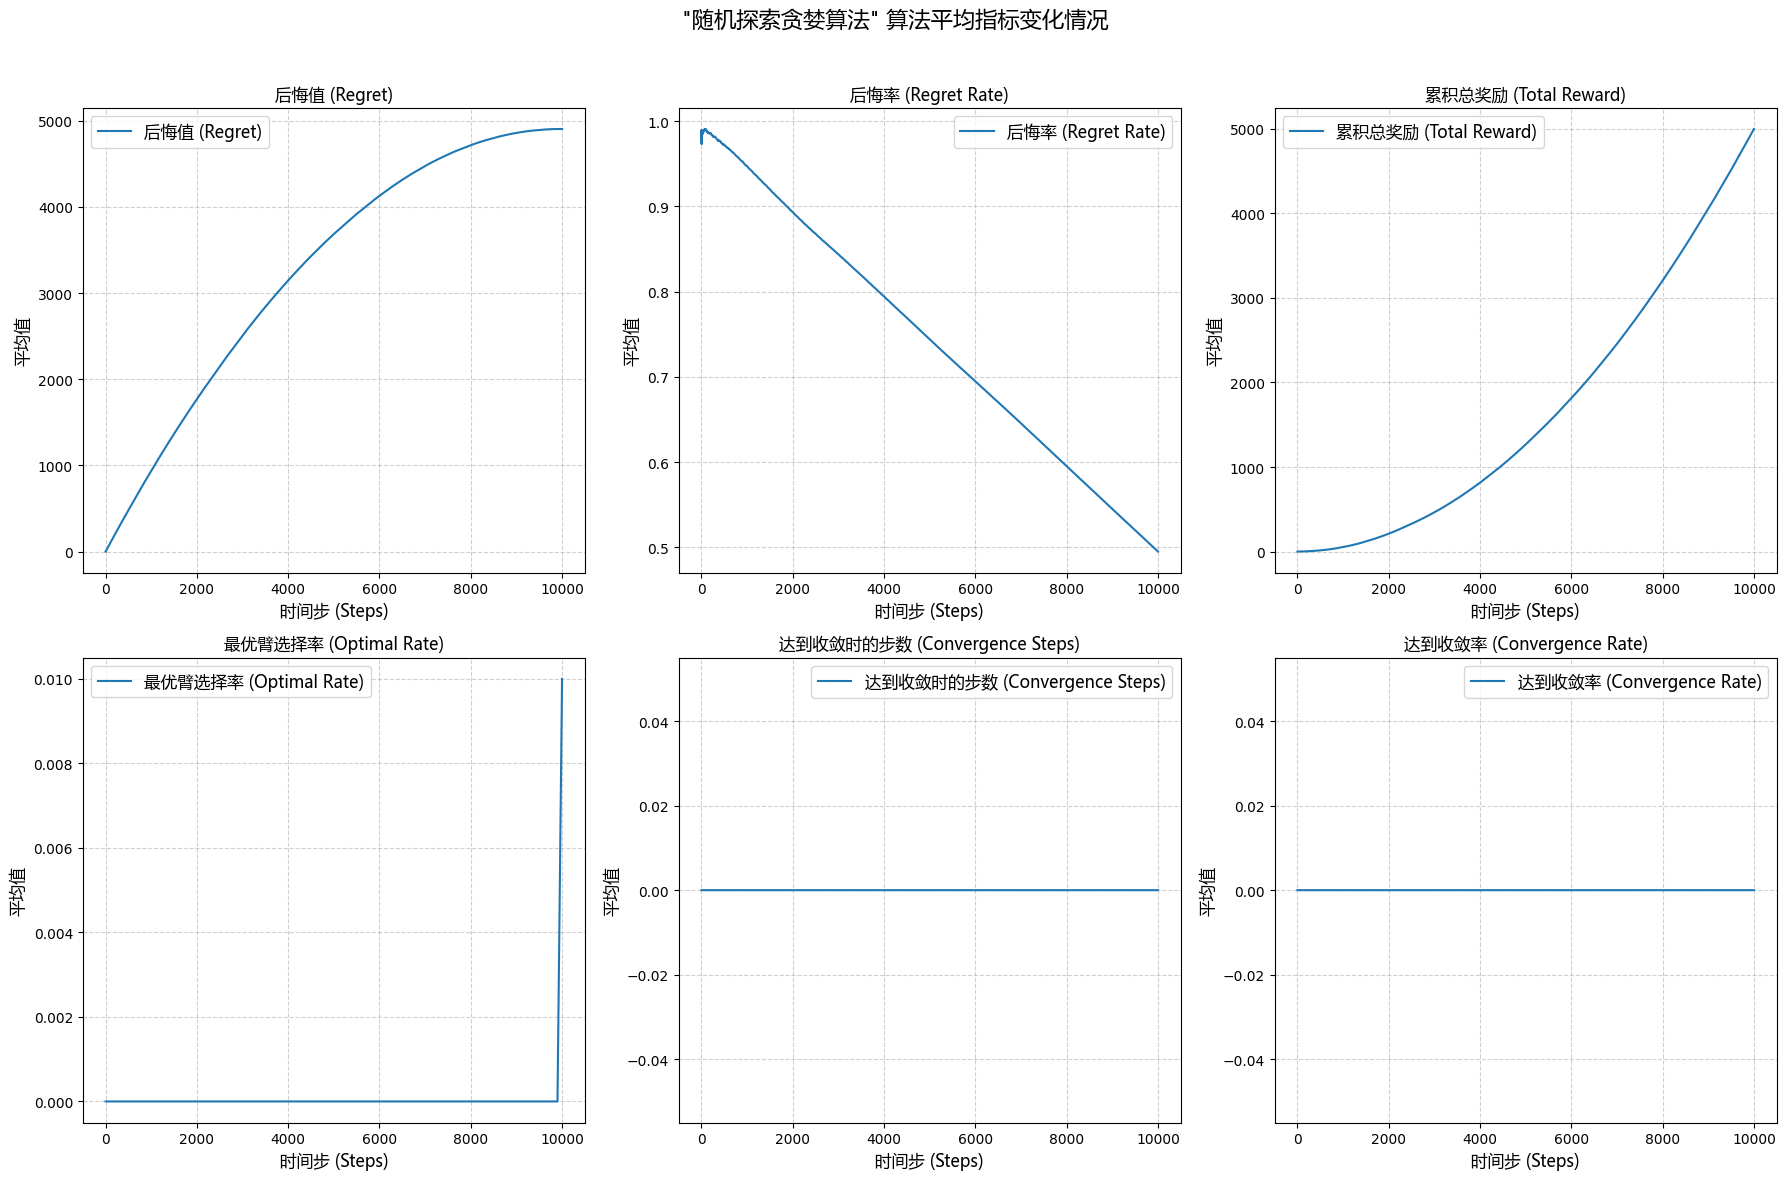

✅ 实验数据已保存至 epsilon_average_Q_0=100.png
anget 名称: epsilon_average
平均奖励：values=[0.94, 1.8, 2.68, 3.62, 4.56, 5.46, 6.54, 7.76, 8.72, 9.98, 11.14, 12.22, 13.4, 14.38, 15.46, 16.58, 17.44, 18.36, 19.56, 20.68, 21.56, 22.28, 23.24, 23.88, 24.8, 25.64, 26.42, 27.2, 28.22, 29.22, 30.42, 31.46, 32.56, 33.56, 34.58, 35.56, 36.56, 37.62, 38.74, 39.68, 40.66, 41.66, 42.74, 43.64, 44.62, 45.58, 46.64, 47.68, 48.72, 49.94, 50.86, 51.66, 52.4, 53.3, 54.06, 54.98, 55.76, 56.8, 57.74, 58.78, 59.92, 60.84, 61.78, 62.84, 63.7, 64.88, 66.08, 66.88, 68.0, 69.06, 70.3, 71.46, 72.3, 73.2, 74.48, 75.54, 76.44, 77.42, 78.16, 79.26, 80.34, 81.34, 82.5, 83.38, 84.28, 85.08, 86.24, 87.28, 88.24, 89.18, 90.18, 91.12, 91.96, 92.94, 93.96, 94.86, 95.88, 96.96, 98.16, 99.04] counts=[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,

21568

In [5]:
# 随机探索贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 退火随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


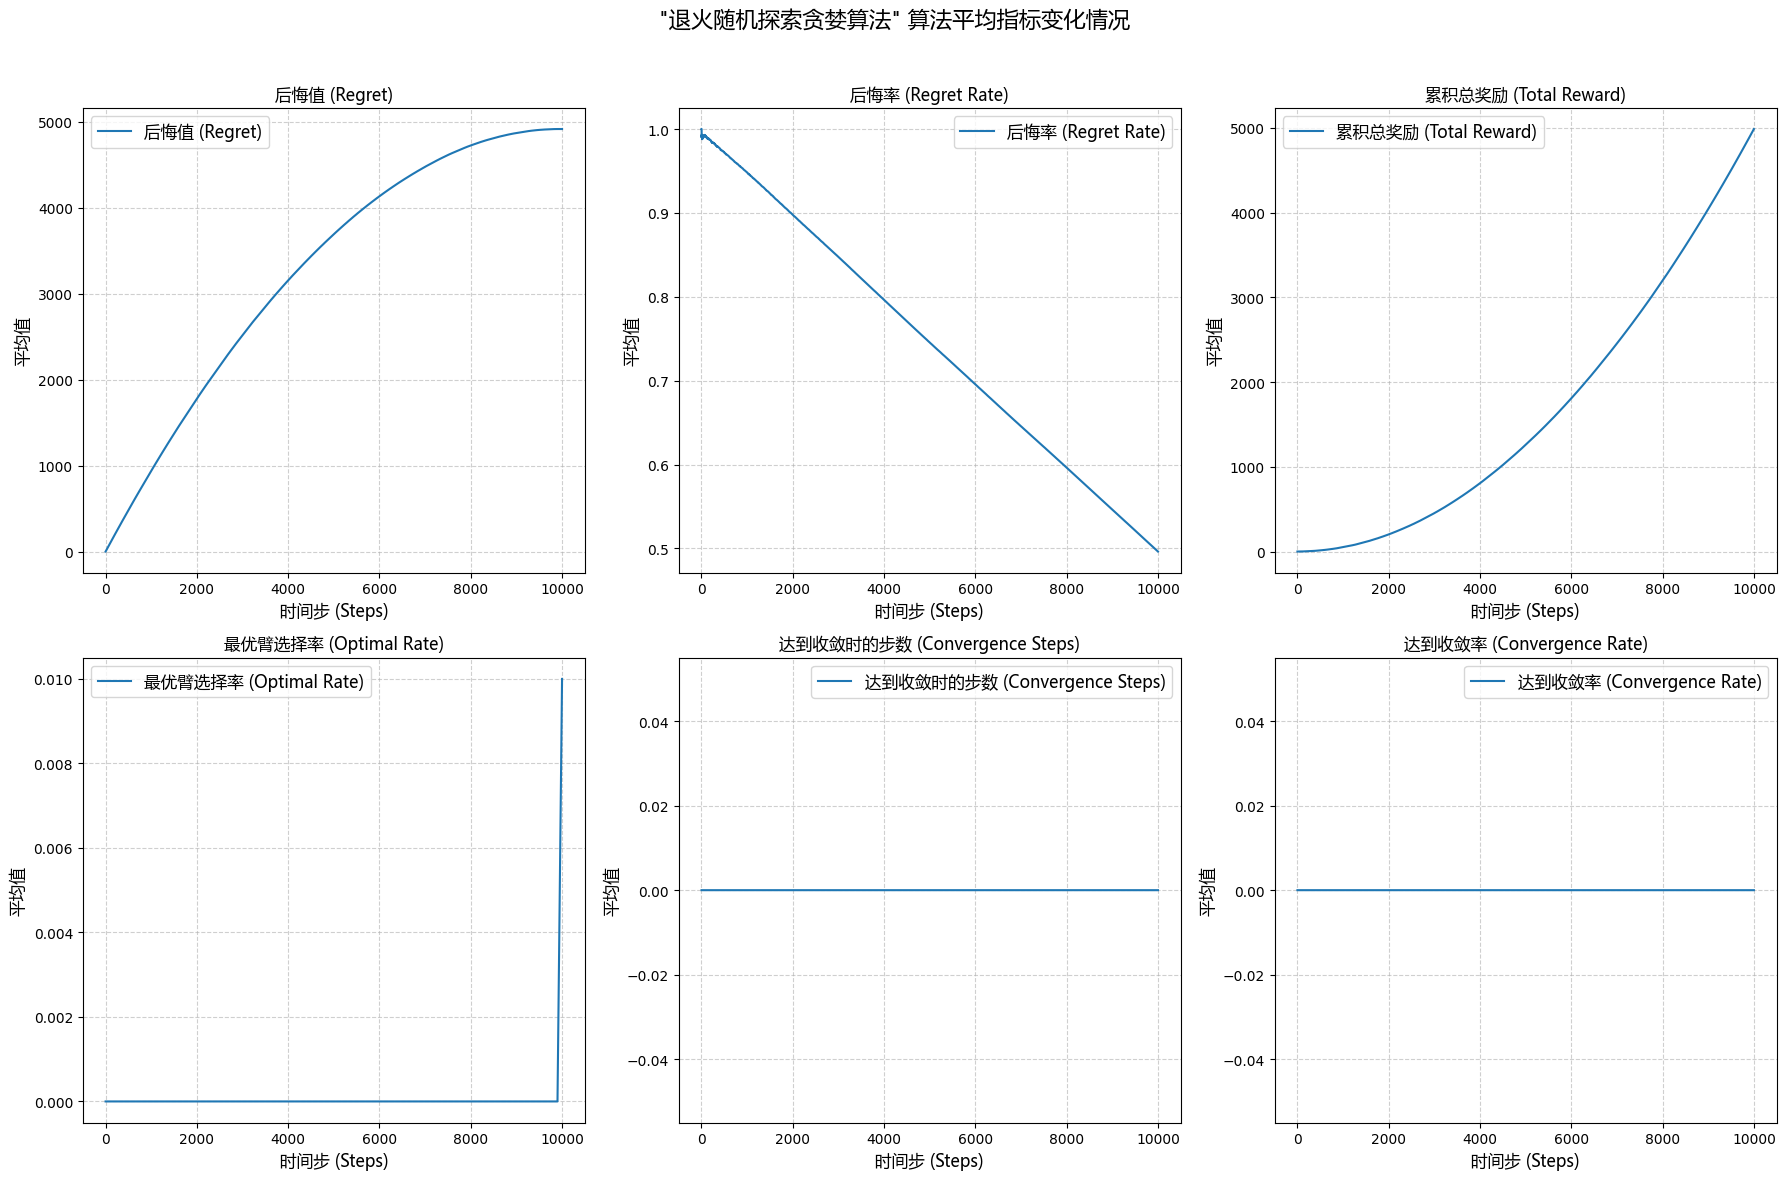

✅ 实验数据已保存至 epsilon_decreasing_average_Q_0=100.png
anget 名称: epsilon_decreasing_average
平均奖励：values=[0.9, 1.76, 2.78, 3.74, 4.64, 5.6, 6.68, 7.34, 8.4, 9.52, 10.52, 11.44, 12.56, 13.52, 14.68, 15.84, 16.62, 17.52, 18.64, 19.64, 20.72, 21.68, 22.64, 23.54, 24.5, 25.48, 26.56, 27.68, 28.46, 29.68, 30.56, 31.7, 32.98, 33.9, 34.94, 35.78, 36.66, 37.96, 38.96, 39.9, 40.92, 41.98, 42.96, 43.94, 44.84, 45.82, 46.84, 47.74, 48.48, 49.66, 50.44, 51.28, 52.18, 53.16, 54.26, 55.26, 56.36, 57.6, 58.44, 59.42, 60.36, 61.48, 62.44, 63.4, 64.44, 65.46, 66.34, 67.26, 67.92, 68.74, 69.8, 70.64, 71.52, 72.46, 73.46, 74.64, 75.62, 76.76, 77.82, 78.86, 79.96, 81.12, 81.98, 83.06, 84.26, 84.94, 86.06, 87.08, 87.94, 88.92, 89.9, 90.8, 91.8, 92.8, 93.84, 95.08, 96.1, 96.86, 97.86, 99.06] counts=[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 

21568

In [6]:
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_decreasing_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="退火随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()